# Predicting Shelter Animal Outcomes

## Importing the libraries

In [63]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import log_loss
import xgboost as xgb
seed = 1024
np.random.seed(seed)

## Importing the dataset

In [64]:
train = pd.read_csv('data/train.csv',parse_dates=['DateTime']).fillna('')
test = pd.read_csv('data/test.csv',parse_dates=['DateTime']).fillna('')

## Feature Engineering

In [65]:
y = train['OutcomeType'].values
le_y = LabelEncoder()

y = le_y.fit_transform(y)
print(le_y.classes_)

train = train.drop('OutcomeType',axis=1)
train = train.drop('OutcomeSubtype',axis=1)

train['ColorCount'] = train['Color'].apply(lambda x: len(x.split('/')))
train['MixOrNot'] = train['Breed'].apply(lambda x: 'Mix' in x)
train['BreedCount'] = train['Breed'].apply(lambda x: len(x.split('/')))
train['SexPrefix'] = train['SexuponOutcome'].apply(lambda x: x.split(' ')[0])
train['DateTime_dayofweek'] = train['DateTime'].dt.dayofweek
train['DateTime_dayofyear'] = train['DateTime'].dt.dayofyear
train['DateTime_days_in_month'] = train['DateTime'].dt.days_in_month

test['ColorCount'] = test['Color'].apply(lambda x: len(x.split('/')))
test['MixOrNot'] = test['Breed'].apply(lambda x: 'Mix' in x)
test['BreedCount'] = test['Breed'].apply(lambda x: len(x.split('/')))
test['SexPrefix'] = test['SexuponOutcome'].apply(lambda x: x.split(' ')[0])
test['DateTime_dayofweek'] = test['DateTime'].dt.dayofweek
test['DateTime_dayofyear'] = test['DateTime'].dt.dayofyear
test['DateTime_days_in_month'] = test['DateTime'].dt.days_in_month

['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']


In [66]:
data_all = pd.concat([train,test])
data_all = data_all.drop('AnimalID',axis=1)
data_all = data_all.drop('ID',axis=1)

In [67]:
print data_all

      AgeuponOutcome AnimalType                                 Breed  \
0             1 year        Dog                 Shetland Sheepdog Mix   
1             1 year        Cat                Domestic Shorthair Mix   
2            2 years        Dog                          Pit Bull Mix   
3            3 weeks        Cat                Domestic Shorthair Mix   
4            2 years        Dog           Lhasa Apso/Miniature Poodle   
5            1 month        Dog     Cairn Terrier/Chihuahua Shorthair   
6            3 weeks        Cat                Domestic Shorthair Mix   
7            3 weeks        Cat                Domestic Shorthair Mix   
8           5 months        Dog         American Pit Bull Terrier Mix   
9             1 year        Dog                         Cairn Terrier   
10           2 years        Cat                Domestic Shorthair Mix   
11           2 years        Dog               Miniature Schnauzer Mix   
12           4 years        Dog                    

In [68]:
X = []
X_t = []
for c in data_all.columns:
    le = LabelEncoder()
    le.fit(data_all[c].values)
    X.append(le.transform(train[c].values))
    X_t.append(le.transform(test[c].values))

In [69]:
X = np.vstack(X).T
X_t = np.vstack(X_t).T

In [70]:
def make_mf_classifier(X ,y, clf, X_test,n_folds=2, n_round=5):
    n = X.shape[0]
    '''
    Fit metafeature by @clf and get prediction for test. Assumed that @clf -- classifier
    '''
    len_y = len(np.unique(y))
    mf_tr = np.zeros((X.shape[0],len_y))

    mf_te = np.zeros((X_test.shape[0],len_y))

    for i in range(n_round):
        skf = StratifiedKFold(y, n_folds=n_folds, shuffle=True, random_state=42+i*1000)
        for ind_tr, ind_te in skf:
            X_tr = X[ind_tr]
            X_te = X[ind_te]

            y_tr = y[ind_tr]
            y_te = y[ind_te]
            clf.fit(X_tr, y_tr)

            mf_tr[ind_te] += clf.predict_proba(X_te)
            mf_te += clf.predict_proba(X_test)*0.5
            y_pred = clf.predict_proba(X_te)
            score = log_loss(y_te, y_pred)
            print('pred[{}],score[{}]'.format(i,score))
    return (mf_tr / n_round, mf_te / n_round)

In [71]:
skf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)
for ind_tr, ind_te in skf:
    X_train = X[ind_tr]
    X_test = X[ind_te]

    y_train = y[ind_tr]
    y_test = y[ind_te]
    break

In [72]:
print(X_train.shape,X_test.shape)
print X_train

((21381, 14), (5348, 14))
[[   6    0  775 ..., 2266    3    4]
 [  22    1 1293 ..., 5501    2    3]
 [  27    0  775 ...,    0    1    2]
 ..., 
 [   3    0  775 ...,    0    1    2]
 [  26    0  775 ...,    0    3    4]
 [  32    1 1239 ..., 7917    2    3]]


In [73]:
xgboost = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate = 0.03,
        max_depth=6,
        subsample=0.7,
        colsample_bytree = 0.7,
        # gamma = 0.7,
        # max_delta_step=0.1,
        reg_lambda = 4,
        # min_child_weight=50,
        seed = seed,
        )

In [74]:
xgboost.fit(
    X_train,
    y_train,
    eval_metric='mlogloss',
    eval_set=[(X_train,y_train),(X_test,y_test)],
    early_stopping_rounds=100,
    )

[0]	validation_0-mlogloss:1.58113	validation_1-mlogloss:1.5816
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.55431	validation_1-mlogloss:1.55539
[2]	validation_0-mlogloss:1.52948	validation_1-mlogloss:1.53118
[3]	validation_0-mlogloss:1.50948	validation_1-mlogloss:1.51164
[4]	validation_0-mlogloss:1.48741	validation_1-mlogloss:1.49009
[5]	validation_0-mlogloss:1.46515	validation_1-mlogloss:1.46834
[6]	validation_0-mlogloss:1.44491	validation_1-mlogloss:1.44873
[7]	validation_0-mlogloss:1.42669	validation_1-mlogloss:1.4312
[8]	validation_0-mlogloss:1.40841	validation_1-mlogloss:1.41352
[9]	validation_0-mlogloss:1.39001	validation_1-mlogloss:1.39573
[10]	validation_0-mlogloss:1.37202	validation_1-mlogloss:1.37826
[11]	validation_0-mlogloss:1.35463	validation_1-mlogloss:1.36139
[12]	validation_0-mlogloss:1.33782	validation_1-mlogloss:1.34497

[122]	validation_0-mlogloss:0.837804	validation_1-mlogloss:0.891432
[123]	validation_0-mlogloss:0.836576	validation_1-mlogloss:0.890673
[124]	validation_0-mlogloss:0.835451	validation_1-mlogloss:0.889879
[125]	validation_0-mlogloss:0.834329	validation_1-mlogloss:0.889067
[126]	validation_0-mlogloss:0.833236	validation_1-mlogloss:0.888286
[127]	validation_0-mlogloss:0.832028	validation_1-mlogloss:0.887404
[128]	validation_0-mlogloss:0.830875	validation_1-mlogloss:0.886613
[129]	validation_0-mlogloss:0.829764	validation_1-mlogloss:0.885802
[130]	validation_0-mlogloss:0.828798	validation_1-mlogloss:0.885087
[131]	validation_0-mlogloss:0.827697	validation_1-mlogloss:0.884444
[132]	validation_0-mlogloss:0.826674	validation_1-mlogloss:0.883824
[133]	validation_0-mlogloss:0.825517	validation_1-mlogloss:0.883087
[134]	validation_0-mlogloss:0.824372	validation_1-mlogloss:0.882275
[135]	validation_0-mlogloss:0.823443	validation_1-mlogloss:0.881768
[136]	validation_0-mlogloss:0.822483	validation_

[243]	validation_0-mlogloss:0.753814	validation_1-mlogloss:0.848296
[244]	validation_0-mlogloss:0.753425	validation_1-mlogloss:0.84813
[245]	validation_0-mlogloss:0.752967	validation_1-mlogloss:0.848016
[246]	validation_0-mlogloss:0.752422	validation_1-mlogloss:0.847854
[247]	validation_0-mlogloss:0.75201	validation_1-mlogloss:0.8477
[248]	validation_0-mlogloss:0.751584	validation_1-mlogloss:0.847516
[249]	validation_0-mlogloss:0.751184	validation_1-mlogloss:0.847354
[250]	validation_0-mlogloss:0.750761	validation_1-mlogloss:0.84728
[251]	validation_0-mlogloss:0.750201	validation_1-mlogloss:0.847089
[252]	validation_0-mlogloss:0.749713	validation_1-mlogloss:0.84696
[253]	validation_0-mlogloss:0.749305	validation_1-mlogloss:0.846917
[254]	validation_0-mlogloss:0.748876	validation_1-mlogloss:0.846795
[255]	validation_0-mlogloss:0.748249	validation_1-mlogloss:0.846551
[256]	validation_0-mlogloss:0.747762	validation_1-mlogloss:0.846406
[257]	validation_0-mlogloss:0.747145	validation_1-mlog

[364]	validation_0-mlogloss:0.705458	validation_1-mlogloss:0.837377
[365]	validation_0-mlogloss:0.705072	validation_1-mlogloss:0.837188
[366]	validation_0-mlogloss:0.704749	validation_1-mlogloss:0.837181
[367]	validation_0-mlogloss:0.704452	validation_1-mlogloss:0.83709
[368]	validation_0-mlogloss:0.704103	validation_1-mlogloss:0.837032
[369]	validation_0-mlogloss:0.703738	validation_1-mlogloss:0.837004
[370]	validation_0-mlogloss:0.703346	validation_1-mlogloss:0.83694
[371]	validation_0-mlogloss:0.703076	validation_1-mlogloss:0.836893
[372]	validation_0-mlogloss:0.702803	validation_1-mlogloss:0.836843
[373]	validation_0-mlogloss:0.702494	validation_1-mlogloss:0.836783
[374]	validation_0-mlogloss:0.702217	validation_1-mlogloss:0.836743
[375]	validation_0-mlogloss:0.701921	validation_1-mlogloss:0.83669
[376]	validation_0-mlogloss:0.701554	validation_1-mlogloss:0.836675
[377]	validation_0-mlogloss:0.701225	validation_1-mlogloss:0.836575
[378]	validation_0-mlogloss:0.700833	validation_1-m

[485]	validation_0-mlogloss:0.666561	validation_1-mlogloss:0.831984
[486]	validation_0-mlogloss:0.666328	validation_1-mlogloss:0.831967
[487]	validation_0-mlogloss:0.666081	validation_1-mlogloss:0.832022
[488]	validation_0-mlogloss:0.665784	validation_1-mlogloss:0.832048
[489]	validation_0-mlogloss:0.665588	validation_1-mlogloss:0.83199
[490]	validation_0-mlogloss:0.665364	validation_1-mlogloss:0.831957
[491]	validation_0-mlogloss:0.665044	validation_1-mlogloss:0.831926
[492]	validation_0-mlogloss:0.664771	validation_1-mlogloss:0.831895
[493]	validation_0-mlogloss:0.664423	validation_1-mlogloss:0.831908
[494]	validation_0-mlogloss:0.664157	validation_1-mlogloss:0.831894
[495]	validation_0-mlogloss:0.66383	validation_1-mlogloss:0.831865
[496]	validation_0-mlogloss:0.663459	validation_1-mlogloss:0.831769
[497]	validation_0-mlogloss:0.663139	validation_1-mlogloss:0.831757
[498]	validation_0-mlogloss:0.662896	validation_1-mlogloss:0.831757
[499]	validation_0-mlogloss:0.662594	validation_1-

[606]	validation_0-mlogloss:0.633343	validation_1-mlogloss:0.829612
[607]	validation_0-mlogloss:0.632991	validation_1-mlogloss:0.829621
[608]	validation_0-mlogloss:0.632739	validation_1-mlogloss:0.829662
[609]	validation_0-mlogloss:0.632479	validation_1-mlogloss:0.829633
[610]	validation_0-mlogloss:0.632242	validation_1-mlogloss:0.829664
[611]	validation_0-mlogloss:0.631966	validation_1-mlogloss:0.829648
[612]	validation_0-mlogloss:0.631659	validation_1-mlogloss:0.829653
[613]	validation_0-mlogloss:0.63131	validation_1-mlogloss:0.829643
[614]	validation_0-mlogloss:0.631001	validation_1-mlogloss:0.8296
[615]	validation_0-mlogloss:0.630725	validation_1-mlogloss:0.829639
[616]	validation_0-mlogloss:0.630409	validation_1-mlogloss:0.829616
[617]	validation_0-mlogloss:0.630136	validation_1-mlogloss:0.829576
[618]	validation_0-mlogloss:0.629881	validation_1-mlogloss:0.829589
[619]	validation_0-mlogloss:0.629579	validation_1-mlogloss:0.829637
[620]	validation_0-mlogloss:0.629384	validation_1-m

[727]	validation_0-mlogloss:0.602828	validation_1-mlogloss:0.829578
[728]	validation_0-mlogloss:0.602599	validation_1-mlogloss:0.829629
[729]	validation_0-mlogloss:0.602324	validation_1-mlogloss:0.829665
[730]	validation_0-mlogloss:0.602106	validation_1-mlogloss:0.829574
[731]	validation_0-mlogloss:0.601841	validation_1-mlogloss:0.829601
[732]	validation_0-mlogloss:0.601669	validation_1-mlogloss:0.829648
[733]	validation_0-mlogloss:0.601469	validation_1-mlogloss:0.829625
[734]	validation_0-mlogloss:0.601198	validation_1-mlogloss:0.829566
[735]	validation_0-mlogloss:0.600987	validation_1-mlogloss:0.829558
[736]	validation_0-mlogloss:0.600793	validation_1-mlogloss:0.829513
[737]	validation_0-mlogloss:0.600609	validation_1-mlogloss:0.82955
Stopping. Best iteration:
[637]	validation_0-mlogloss:0.6251	validation_1-mlogloss:0.829399



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=4,
       scale_pos_weight=1, seed=1024, silent=True, subsample=0.7)

In [75]:
y_preds = xgboost.predict_proba(X_test)

In [76]:
res = xgboost.predict_proba(X_t)

In [77]:
submission = pd.DataFrame()
submission["ID"] = np.arange(res.shape[0])+1
submission["Adoption"]= res[:,0]
submission["Died"]= res[:,1]
submission["Euthanasia"]= res[:,2]
submission["Return_to_owner"]= res[:,3]
submission["Transfer"]= res[:,4]

In [78]:
submission.to_csv("result/predictions_v2.csv",index=False)

In [79]:
from xgboost import plot_importance
from matplotlib import pyplot

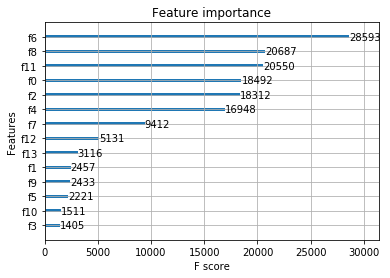

In [80]:
plot_importance(xgboost)
pyplot.show()
# features are automatically named according to their index in the input array (X) from F0 to F7.

In [81]:
print data_all

      AgeuponOutcome AnimalType                                 Breed  \
0             1 year        Dog                 Shetland Sheepdog Mix   
1             1 year        Cat                Domestic Shorthair Mix   
2            2 years        Dog                          Pit Bull Mix   
3            3 weeks        Cat                Domestic Shorthair Mix   
4            2 years        Dog           Lhasa Apso/Miniature Poodle   
5            1 month        Dog     Cairn Terrier/Chihuahua Shorthair   
6            3 weeks        Cat                Domestic Shorthair Mix   
7            3 weeks        Cat                Domestic Shorthair Mix   
8           5 months        Dog         American Pit Bull Terrier Mix   
9             1 year        Dog                         Cairn Terrier   
10           2 years        Cat                Domestic Shorthair Mix   
11           2 years        Dog               Miniature Schnauzer Mix   
12           4 years        Dog                    